# PyTorch Auto Diff Engine
Reference
- [Overview of PyTorch Autograd Engine](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/)
- [ezyang's blog](http://blog.ezyang.com/2019/05/pytorch-internals/)
- [Connection between loss.backward() and optimizer.step()](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step)

In [2]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from matplotlib import pyplot as plt

## Compute gradient with torch

We previous described Automatic Differentiation in this [post](https://martj001.github.io/paxillifer-test/post-ml/ml,%20dl/2021/11/14/auto-diff.html). PyTorch basically implements the Reverse mode AD. The derivative rules are defined in this [yaml file](https://github.com/pytorch/pytorch/blob/a0a7a2d648f05b0192e6943c9684406cdf404fbf/tools/autograd/derivatives.yaml). Every time we declared a tensor `x` with `requires_grad = True` argument, the autograd engine constructs a computation graph. When we perform operations on this tensor more nodes will be added to this computation graph. When we call `y.backward()` on some non-leaf tensor, the autograd engine will traverse the computation graph and compute the gradient backward.

Consider the example in our Automatic Differentiation post:

$$f(x_1, x_2) = \ln(x_1) + x_1x_2 − \sin(x_2)$$

evaluated at $x_1 = 2, x_2 = 5$


In [114]:
def f(x1, x2):
    y = torch.log(x1) + x1*x2 - torch.sin(x2)
    
    return y

x1 = torch.tensor([2.0], requires_grad = True)
x2 = torch.tensor([5.0], requires_grad = True)
y = f(x1, x2)
y.backward()
print(x1.grad)
print(x2.grad)

tensor([5.5000])
tensor([1.7163])


Not surprisingly, torch's result matches our manual derivation

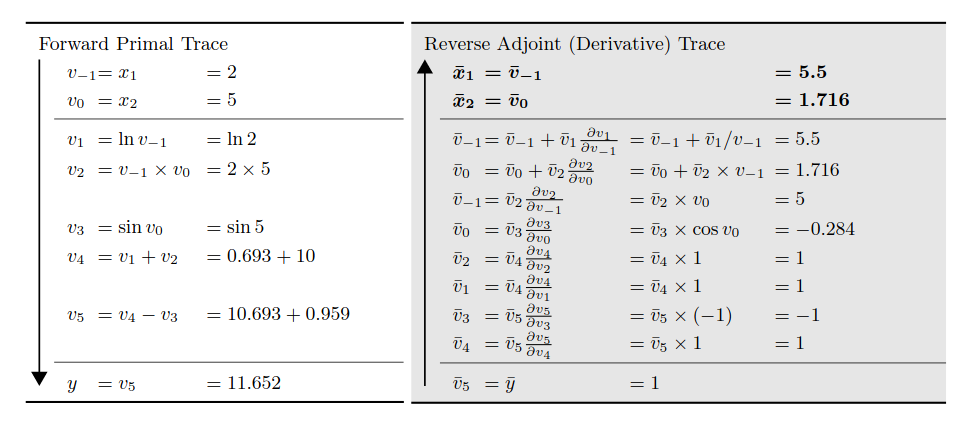


Similar to the manual derivation where we set $\bar{v}_5 = 1$, we need to set gradient on `y` to start the calculation. We can omit this due to 'None values can be specified for scalar Tensors' stated in [this documentation](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html). Note that we will get same result when we explicitly set `y.backward(gradient = torch.tensor([1.0]))`


In [121]:
x1 = torch.tensor([2.0], requires_grad = True)
x2 = torch.tensor([5.0], requires_grad = True)
y = f(x1, x2)
y.backward(gradient = torch.tensor([1.0]))
print(x1.grad)
print(x2.grad)

tensor([5.5000])
tensor([1.7163])


## Optimization with torch

Suppose we want to find the local minimum of $f(x) = x^2$ from $x = 5$, with torch's auto-diff and optimizer (say `torch.nn.optim.SGD`). The optimizer takes a iterable of parameters or `torch.tensor`. Each time we call `y.backward()`, gradient on all leaf node or `x` will be computed. When we call `optimizer.step()`, a parameter update will be performed on all `x` with `requires_grad = True`, which is shown below:

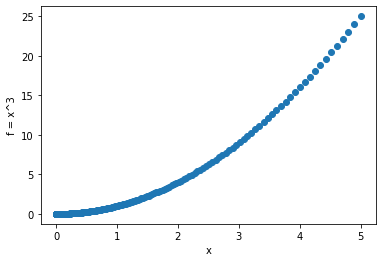

[5.0, 4.9, 4.802, 4.7059603, 4.611841, 4.519604, 4.429212, 4.3406277, 4.253815, 4.168739]


In [111]:
def f(x):
    y = x*x
    
    return y

x_list = [5.0]
y_list = []

x = torch.tensor([5.0], requires_grad = True)

lr = 1e-2
opt = SGD([x], lr)

for i in range(1000):
    y = f(x)
    opt.zero_grad()
    y.backward()
    opt.step()

    x_list.append(x.detach().numpy()[0])
    y_list.append(y.detach().numpy()[0])
    
plt.scatter(x_list[:-1], y_list)
plt.xlabel('x')
plt.ylabel('f = x^3')
plt.show()

print(x_list[0:10])

Note that in this example, we are optimizing `x` for `y = f(x)`. When we train a neural network, the above equation becomes `loss = f(w;x)`. The weight parameters `w` of the network are being optimized, with repect to some function defined by our data `x`. When we change the data, `f` is also changed and `w` may no longer minimize `loss`. This can be viewed as the source of the generalization error.

Note that for reverse mode AD, gradient are accumulated on each node of computation graph. Therefore you cannot call `y.backward()` twice. 

In [122]:
x = torch.tensor([5.0], requires_grad = True)
y = x*x
y.backward()
y.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.